# Projekt: Klasyfikacja Recenzji Filmowych (IMDB) z użyciem TensorFlow

## Wstęp do projektu

Celem niniejszego projektu jest stworzenie i porównanie czterech różnych modeli sieci neuronowych do klasyfikacji recenzji filmowych jako pozytywne lub negatywne. W projekcie wykorzystano popularny zbiór danych IMDB Reviews, zawierający 50 000 recenzji filmów, równomiernie podzielonych na klasy pozytywne i negatywne.

Projekt realizowany jest w języku Python z użyciem biblioteki TensorFlow, w środowisku Google Colab. Przed przystąpieniem do budowy modeli wykonano podstawowy preprocessing danych, w tym wektoryzację tekstów, ustalenie długości sekwencji oraz przygotowanie danych treningowych i testowych.

W ramach projektu zaimplementowano i przetestowano cztery różne architektury sieci neuronowych:

  - MLP (Multilayer Perceptron) - prosty model gęsto połączony, używany jako baseline.

  - LSTM (Long Short-Term Memory) - sieć rekurencyjna, lepiej radząca sobie z analizą sekwencji.

  - CNN (Convolutional Neural Network) - sieć konwolucyjna, która wykrywa lokalne wzorce w tekście.

  - GRU + Attention (Gated Recurrent Unit z mechanizmem uwagi) - lekka sieć rekurencyjna, która zapamiętuje kontekst sekwencji i skupia się na najważniejszych słowach dzięki warstwie uwagi (attention). Działa szybciej niż LSTM i często osiąga podobne wyniki.

Każdy z modeli został oceniony na podstawie metryk takich jak dokładność (accuracy), strata (loss), macierz błędów oraz krzywe uczenia się. Na końcu projektu dokonano porównania skuteczności wszystkich modeli i wskazano najlepszy z nich wraz z uzasadnieniem wyboru.

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers, models

## Załadowanie danych


In [5]:
# Załadowanie surowego zbiór danych (bez podziału na (x, y)), aby pobrać same teksty
raw_train = tfds.load("imdb_reviews", split="train", as_supervised=False)
raw_test = tfds.load("imdb_reviews", split="test", as_supervised=False)

# Wyciągamy tylko teksty z pierwszych 10 000 przykładów do dopasowania warstwy wektoryzującej
text_list = [ex["text"].numpy().decode("utf-8") for ex in raw_train.take(10000)]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.T5AYZD_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.T5AYZD_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.T5AYZD_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


## Warstwa wektoryzująca

**Uwaga:** Dlaczego najpierw ładujemy dane jako as_supervised=False, a później znowu jako as_supervised=True (czyli z podziałem na tekst i etykiety) w dalszej części projektu?

Surowe dane (as_supervised=False) są wykorzystywane tylko do adapt(). Metoda adapt() przygotowuje warstwę TextVectorization do pracy z tekstami.
Inaczej mówiąc uczy ją słownika słów (jakie słowa istnieją i jakie mają numery), zanim zaczniemy zamieniać teksty na liczby. Bez niej TextVectorization nie wie, jakie słowa istnieją i nie umie ich zamieniać na liczby.

**Działanie adapt() w warstwie TextVectorization**
1. Przekazujemy do adapt() listę tekstów np. ["this movie is great", "awful plot"],
2. Każdy tekst dzieli na słowa,
3. Liczy, ile razy każde słowo się pojawiło,
4. Wybiera najczęstsze słowa (np. top 10 000) i przypisuje im numery,
5. Warstwa zapamiętuje ten słownik, żeby później automatycznie zamieniać nowe teksty na liczby.



In [6]:
# Ustawiamy warstwę wektoryzującą teksty: ograniczamy słownik do 10k słów, wyjściowa sekwencja ma długość 250
VOCAB_SIZE = 10000  # Maksymalna liczba unikalnych słów w słowniku
SEQUENCE_LENGTH = 250  # Długość sekwencji wejściowej ( uporządkowana lista elementów (np. słów), którą model analizuje w ustalonej, równej długości)

vectorize_layer = layers.TextVectorization(
    max_tokens=VOCAB_SIZE,  # Maksymalnie 10k słów
    output_mode='int',      # Zwracane będą liczby całkowite (indeksy słów)
    output_sequence_length=SEQUENCE_LENGTH  # Wszystkie recenzje będą miały długość 250 słów
)

# Dopasowanie warstwy wektoryzującej do danych tekstowych
vectorize_layer.adapt(text_list)


## Przetwarzanie danych i wizualizacja

Elementy użyte do przetwarzania danych - opis:

   - Wektoryzacja (Text Vectorization)

Wektoryzacja to proces zamiany tekstu (czyli ciągów znaków, np. recenzji) na liczby, które mogą być przetwarzane przez modele uczenia maszynowego. Zamiast słów używamy ich reprezentacji liczbowej - np. każde słowo może zostać zamienione na unikalny indeks ze słownika.

   - Losowe tasowanie (Shuffle)

Losowe tasowanie danych sprawia, że model nie uczy się na danych w tej samej kolejności w każdej epoce, co zapobiega tzw. „przeuczeniu na kolejności” i pozwala lepiej uogólniać wyniki.

   - Batching (podział na partie)

Zamiast przekazywać wszystkie dane naraz, dzielimy je na mniejsze fragmenty (np. po 32 próbki), które model przetwarza w jednym kroku. Przyspiesza to trening i pozwala lepiej wykorzystać pamięć komputera.

   - Cache (buforowanie)

Buforowanie danych oznacza ich zapisanie w pamięci RAM, aby nie trzeba było za każdym razem przetwarzać ich od nowa (np. tokenizacji, uniknięcie przeliczania od nowa w każdej epoce treningu). Dzięki temu trening działa szybciej i płynniej.

In [7]:
# Załadowanie danych z podziałem na (tekst, etykieta)
train_data = tfds.load("imdb_reviews", split="train", as_supervised=True)
test_data = tfds.load("imdb_reviews", split="test", as_supervised=True)

"""
Parametr as_supervised=True w funkcji tfds.load() oznacza, że dane będą załadowane jako pary (x, y), czyli:

    x - dane wejściowe (np. tekst recenzji),

    y - etykieta (np. 0 = negatywna, 1 = pozytywna).
"""

'\nParametr as_supervised=True w funkcji tfds.load() oznacza, że dane będą załadowane jako pary (x, y), czyli:\n\n    x – dane wejściowe (np. tekst recenzji),\n\n    y – etykieta (np. 0 = negatywna, 1 = pozytywna).\n'

In [8]:
# Wizualizacja danych
# Podgląd pierwszych 5 recenzji z etykietami
for i, (text, label) in enumerate(train_data.take(5)):
    print(f"Recenzja {i+1}:")
    print(text.numpy().decode("utf-8"))
    print(f"Etykieta: {'Pozytywna' if label.numpy() == 1 else 'Negatywna'}")
    print("-" * 80)

Recenzja 1:
This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
Etykieta: Negatywna
--------------------------------------------------------------------------------
Recenzja 2:
I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette an

**Rozkład danych w zbiorze treningowym**

Na wykresie widzimy, że liczba recenzji negatywnych i pozytywnych jest niemal taka sama (po około 12 500 przykładów z każdej klasy).

Stąd widzimy, że zbiór danych jest zbalansowany, czyli każda klasa ma podobną liczbę przykładów. Dzięki temu model nie będzie faworyzować żadnej z klas. Na przykład nie nauczy się "domyślnie" przewidywać tylko pozytywnych, bo jest ich więcej.

Równomierny podział klas jest bardzo ważny w klasyfikacji binarnej, ponieważ zmniejsza ryzyko błędnych predykcji wynikających z przewagi jednej klasy.

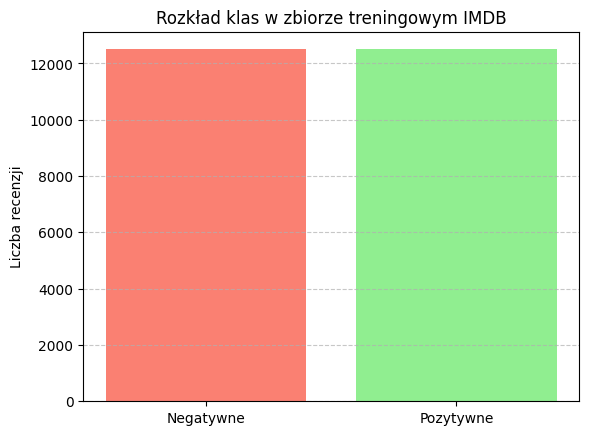

In [9]:
# Wykres liczby recenzji według klasy (negatywne/pozytywne)
# Zliczanie liczby przykładów w każdej klasie
train_labels = [label.numpy() for _, label in train_data]
pos_count = sum(train_labels)
neg_count = len(train_labels) - pos_count

# Tworzenie wykresu
plt.bar(["Negatywne", "Pozytywne"], [neg_count, pos_count], color=["salmon", "lightgreen"])
plt.title("Rozkład klas w zbiorze treningowym IMDB")
plt.ylabel("Liczba recenzji")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Długość recenzji w zbiorze treningowym**

Wykres przedstawia rozkład długości recenzji (w słowach) dla pierwszych 1000 przykładów ze zbioru treningowego IMDB.
Na wykresie widzimy, że:
 - Większość recenzji ma od 100 do 300 słów,
 - Najwięcej recenzji ma około 150 słów,
 - Pojedyncze recenzje mają ponad 500, a nawet 800 słów, ale są to rzadkie przypadki.

 Skoro długość recenzji bardzo się różni, model będzie musiał wykorzystywać TextVectorization z parametrem output_sequence_length=250. Taka wartość parametru pokrywa się z dominującym zakresem długości i pozwala zachować najważniejsze informacje bez obcinania większości tekstów.



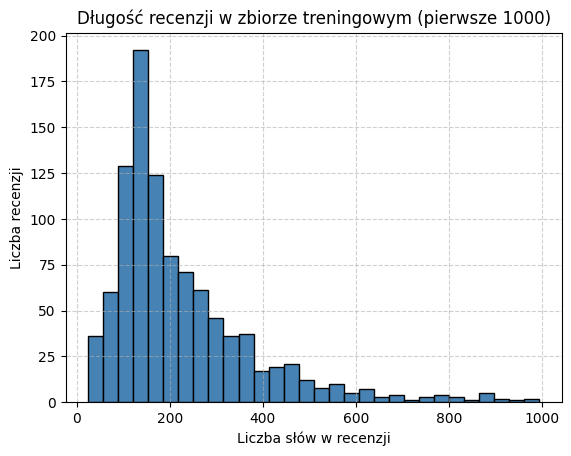

In [10]:
# Wykres długości recenzji (ilość słów)
# Pomiar długości recenzji (w słowach)
review_lengths = [len(text.numpy().decode("utf-8").split()) for text, _ in train_data.take(1000)]

# Histogram długości
plt.hist(review_lengths, bins=30, color="steelblue", edgecolor="black")
plt.title("Długość recenzji w zbiorze treningowym (pierwsze 1000)")
plt.xlabel("Liczba słów w recenzji")
plt.ylabel("Liczba recenzji")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [11]:
# Wektoryzacja danych po podziale na train i test sets

def vectorize_text(text, label):  # Funkcja do zamiany tekstu na liczby całkowite
    return vectorize_layer(text), label  # Wektoryzacja tekstu bez dodatkowego wymiaru

# Zastosowanie wektoryzacji, batching, cache, shuffle, prefetch
train_data = train_data.map(vectorize_text).cache().shuffle(10000).batch(32).prefetch(tf.data.AUTOTUNE)
test_data = test_data.map(vectorize_text).batch(32).cache().prefetch(tf.data.AUTOTUNE)


## Model 1: MLP

MLP to jeden z najprostszych typów sieci neuronowych. Składa się z co najmniej jednej warstwy ukrytej między wejściem a wyjściem.

Działanie MLP:

- Wejście (np. tekst jako wektor liczb).

- Warstwa ukryta: kilka/kilkadziesiąt neuronów przetwarza dane.

- Funkcja aktywacji (np. ReLU) dodaje nieliniowość.

- Wyjście: jeden neuron z funkcją sigmoid, który mówi, czy recenzja jest pozytywna czy negatywna.

In [16]:
# Budujemy model MLP
def build_mlp_model():
    model = models.Sequential([
        layers.Embedding(VOCAB_SIZE, 64),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',  # Automatyczne dostosowanie szybkości uczenia dla każdej wagi
                  metrics=['accuracy'])
    return model

"""
Warstwa Embedding zamienia liczby (indeksy słów) na wektory liczbowe.
Dzięki temu każde słowo jest reprezentowane nie tylko jako liczba (np. 5), ale jako ciąg liczb, który zawiera informację o znaczeniu tego słowa.
NP:
Załóżmy, że słowo "film" ma indeks 42.
Warstwa Embedding przekształci je w taki wektor:
[ 0.25, -0.11, 0.03, ..., 0.72 ]  # np. 64 liczb
Embedding to warstwa, która uczy się sama podczas treningu.
Model sam odkrywa, które słowa są podobne do siebie, patrząc na to, jak wpływają na wynik.
---
layers.GlobalAveragePooling1D()

  - Uśrednia wszystkie wektory słów w recenzji.

  - Po warstwie Embedding każde słowo ma własny wektor (np. 64 liczby).

  - Recenzja o 250 słowach = macierz 250 × 64.

  - Ta warstwa liczy średnią z każdego z 64 wymiarów i zwraca 1 wektor długości 64.

---

layers.Dense(64, activation='relu')

  - Warstwa gęsta z 64 neuronami, które przetwarzają dane z poprzedniego kroku.

  - Każdy neuron łączy się ze wszystkimi wartościami z poprzedniej warstwy.

  - activation='relu' (Rectified Linear Unit) oznacza:

        Jeśli wynik > 0 -> zostaje - jeśli liczba jest dodatnia (np. 3.5) -> funkcja ReLU nie zmienia jej

        Jeśli <= 0 -> zamienia się na 0.
---
layers.Dense(1, activation='sigmoid')

  - Wyjście modelu – pojedyncza wartość od 0 do 1.

  - 1 neuron = decyzja: pozytywna czy negatywna recenzja.

  - sigmoid zamienia wynik na zakres [0, 1] -> czyli prawdopodobieństwo.

  Interpretacja:

    Blisko 1 -> pozytywna recenzja

    Blisko 0 -> negatywna recenzja

---
Adam to jeden z najczęściej używanych optymalizatorów w sieciach neuronowych. Jego zadaniem jest uczyć model, czyli dostosowywać wagi neuronów, tak aby poprawiać wyniki (np. zmniejszać błąd).
---
binary_crossentropy to funkcja błędu (loss function) używana przy klasyfikacji binarnej, czyli gdy mamy tylko 2 klasy (np. pozytywna / negatywna).
Porównuje:

  - prawdziwą etykietę (np. 0 lub 1)

  - z prognozą modelu (np. 0.92 — czyli „92% pewności, że pozytywna”)

I oblicza jak bardzo model się myli.

"""

mlp_model = build_mlp_model()
mlp_model.summary()

# Trening modelu
history_mlp = mlp_model.fit(train_data, validation_data=test_data, epochs=5)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.6642 - loss: 0.5848 - val_accuracy: 0.7770 - val_loss: 0.4454
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8741 - loss: 0.2997 - val_accuracy: 0.8647 - val_loss: 0.3231
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9064 - loss: 0.2350 - val_accuracy: 0.8605 - val_loss: 0.3306
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9118 - loss: 0.2250 - val_accuracy: 0.8668 - val_loss: 0.3282
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9239 - loss: 0.1942 - val_accuracy: 0.8666 - val_loss: 0.3385


## Ocena modelu 1
Z ewaluacji modelu wyciągamy następujące wnioski:
- Model MLP osiąga bardzo dobrą skuteczność: około 83,3%.
- Strata (loss) jest niska i niemal identyczna na obu zbiorach (~0.39), co świadczy o tym, że:

  - model dobrze dopasował się do danych treningowych,

  - według ewaluacji, nie przeuczył się, bo testowe wyniki są równie dobre.




In [17]:
# Ocena modelu
loss_mlp, acc_mlp = mlp_model.evaluate(test_data)
print(f"Test Loss: {loss_mlp:.4f}, Test Accuracy: {acc_mlp:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8369 - loss: 0.3981
Test Loss: 0.3972, Test Accuracy: 0.8354


Macierz błędów pokazuje, jak model poradził sobie z klasyfikacją recenzji jako pozytywne lub negatywne.

W tym przypadku:


  - 11 417 recenzji negatywnych zostało poprawnie rozpoznanych jako negatywne.

  - 9 467 recenzji pozytywnych zostało poprawnie rozpoznanych jako pozytywne.

  - 1 083 recenzji negatywnych błędnie uznano za pozytywne (błąd typu false positive).

  - 3 033 recenzji pozytywnych błędnie uznano za negatywne (błąd typu false negative).

Wnioskujemy zatem, że:
  - Model działa lepiej w rozpoznawaniu recenzji negatywnych niż pozytywnych.

  - Błędy są, ale klasyfikator zachowuje dobrą równowagę i przewiduje poprawnie dużą większość przypadków.

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


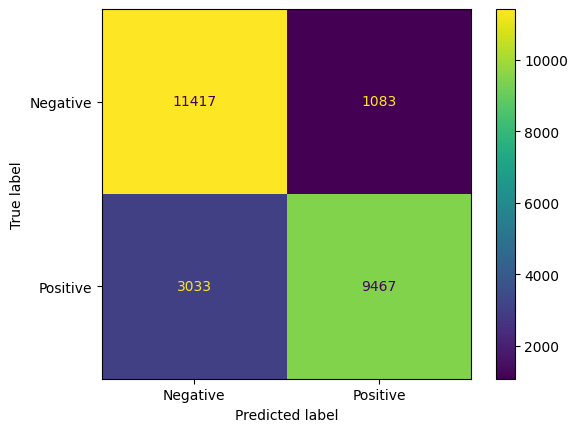

In [18]:
# Macierz błędów
y_true = np.concatenate([y for x, y in test_data], axis=0)
y_pred = (mlp_model.predict(test_data) > 0.5).astype("int32").flatten()

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot()

### Wykres dokładności (MLP Accuracy)

- Niebieska linia (Train Accuracy) - systematycznie rośnie z każdą epoką, co oznacza, że model coraz lepiej dopasowuje się do danych treningowych.
- Pomarańczowa linia (Validation Accuracy) - rośnie tylko do 1. epoki, po czym spada i nie odzyskuje wcześniejszego poziomu.

To sugeruje, że model zaczyna się przeuczać (overfitting) po 1. epoce - zbyt dobrze zapamiętuje dane treningowe, tracąc zdolność generalizacji.

### Wykres błędu (MLP Loss)

- Train Loss (niebieska) — wyraźnie maleje z każdą epoką, co pokazuje skuteczne dopasowanie modelu do danych treningowych.
- Validation Loss (pomarańczowa) — początkowo maleje, ale po 1. epoce zaczyna rosnąć i staje się niestabilna.

To dodatkowy objaw przeuczenia - model zbyt dobrze dopasowuje się do treningu kosztem walidacji.

### Wnioski

- Model MLP szybko się uczy, ale przeucza się już po 1-2 epokach.
- Najlepsze wyniki walidacyjne pojawiają się w 1. epoce.

### Co można poprawić ?:
- Wprowadzenie EarlyStopping, aby zatrzymać trening w najlepszym momencie.
- Dodanie lub wzmocnienie Dropoutu i/lub L2 regularization.
- Zmniejszenie liczby neuronów lub warstw - uproszczenie modelu.

Model MLP osiąga wysoką dokładność, ale wymaga ochrony przed nadmiernym dopasowaniem do danych treningowych.


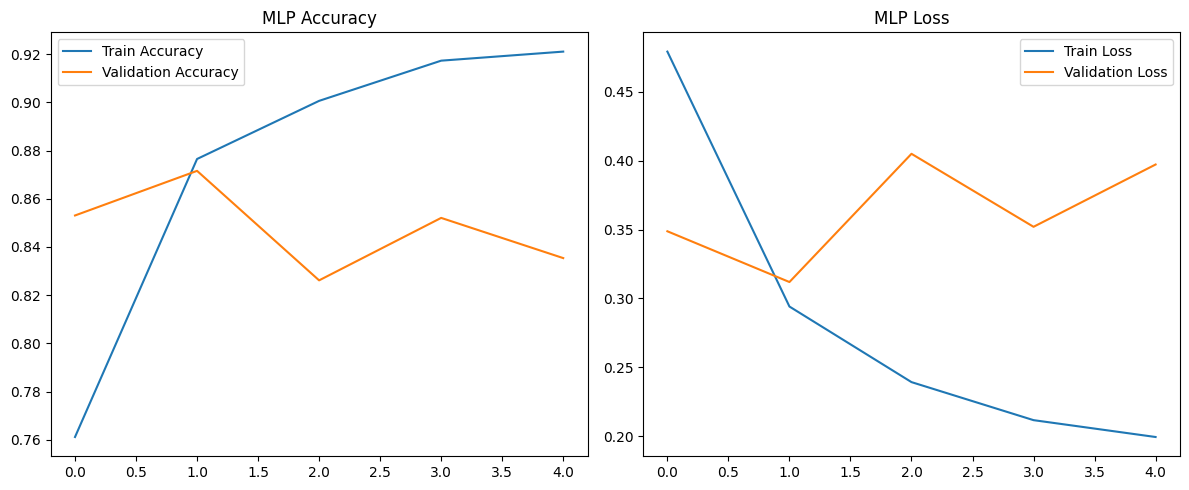

In [19]:
# Krzywe uczenia się
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_mlp.history['accuracy'], label='Train Accuracy')
plt.plot(history_mlp.history['val_accuracy'], label='Validation Accuracy')
plt.title("MLP Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_mlp.history['loss'], label='Train Loss')
plt.plot(history_mlp.history['val_loss'], label='Validation Loss')
plt.title("MLP Loss")
plt.legend()
plt.tight_layout()
plt.show()

### Podsumowanie działania modelu MLP

### Wyniki:
- **Dokładność na zbiorze testowym**: ok. **83%** - model dobrze rozpoznaje emocje recenzji.
- **Macierz błędów** pokazuje, że model:
  - dobrze rozpoznaje recenzje **negatywne**,
  - częściej myli recenzje **pozytywne** jako negatywne.
- **Krzywe uczenia się** wskazują na **przeuczenie (overfitting)** po ok. 1-2 epokach:
  - dokładność na danych treningowych systematycznie rośnie (model coraz lepiej zapamiętuje dane uczące),
  - natomiast dokładność na danych walidacyjnych przestaje rosnąć i zaczyna spadać (model gorzej radzi sobie z nowymi danymi).


### Wnioski:
- Model MLP daje **zadowalające wyniki** przy minimalnym preprocessing'u i prostych warstwach.
- Jest dobrym **punktem wyjścia (baseline)** do dalszych eksperymentów.
- Aby poprawić jego działanie, warto:
  - wprowadzić mechanizmy zapobiegające przeuczeniu,
  - porównać go z bardziej zaawansowanymi architekturami (np. LSTM, CNN)

## Model 2: LSTM

LSTM to rodzaj sieci neuronowej, która analizuje dane sekwencyjne, np. tekst słowo po słowie.
Ma wbudowaną pamięć, dzięki której potrafi zachować kontekst i zrozumieć zależności między słowami oddalonymi w zdaniu.

Dzięki temu LSTM lepiej niż zwykłe sieci (np. MLP) radzi sobie z:

  - analizą dłuższych recenzji,

  - rozumieniem kolejności słów,

  - wykrywaniem sensu całych fraz, a nie tylko pojedynczych słów.

In [17]:
# Tworzymy model LSTM
def build_lstm_model():
    model = models.Sequential([
        layers.Embedding(VOCAB_SIZE, 64),  # Każde słowo zamieniamy na 64-wymiarowy wektor
        # Dwukierunkowa warstwa LSTM – zwraca pełną sekwencję, by można było podłączyć kolejną warstwę
        layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
        layers.Dropout(0.3),  # Dropout – losowo „wycisza” 30% połączeń (zapobiega przeuczeniu)
        # Druga warstwa LSTM – dwukierunkowa, analizuje cały kontekst z poprzedniego poziomu
        layers.Bidirectional(layers.LSTM(32)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),  # Kolejny Dropout
        layers.Dense(1, activation='sigmoid')  # Warstwa wyjściowa – wynik w zakresie 0–1 (pozytywna/negatywna)
    ])
    model.compile(
        loss='binary_crossentropy',  # Funkcja straty dla klasyfikacji binarnej (0/1)
        optimizer='adam',            # Optymalizator Adam: dynamiczne tempo uczenia
        metrics=['accuracy']         # Metryka: dokładność klasyfikacji
    )
    return model

lstm_model = build_lstm_model()
lstm_model.summary()  # Wyświetlamy strukturę modelu

"""
"Dwukierunkowe LSTM: przetwarza dane w obu kierunkach (przód i tył)"
 Inaczej mówiąc LSTM czyta tekst od lewej do prawej i od prawej do lewej. Jest to przydatne, ponieważ czasem znaczenie
 słowa zależy od tego, co jest po nim. Daje to modelowi lepsze zrozumienie całej sekwencji tekstu.

---
return_sequences=True oznacza, że LSTM zwraca wynik dla każdego słowa a nie tylko dla ostatniego.
  NP:
  recenzja ma 250 słów, a warstwa LSTM ma 64 jednostki

    Jeśli return_sequences=True
    -> wynik to macierz o wymiarach (250, 64)
    (czyli LSTM daje „opinię” dla każdego słowa z osobna)

    Jeśli return_sequences=False (domyślnie)
    -> wynik to tylko 1 wektor o długości 64
    (czyli tylko „podsumowanie” całej sekwencji)
---
Dropout to technika „wyłączania” losowych neuronów podczas treningu sieci neuronowej.
A więc podczas każdego kroku treningu, Dropout losowo wyłącza część neuronów (np. 30%),
czyli ignoruje ich wartości i połączenia, ale podczas testowania lub predykcji wszystko działa normalnie.
Dzięki temu model musi uczyć się na różne sposoby i nie polegać na "ulubiony" neuronach.
---

"""

# Trenujemy model
history_lstm = lstm_model.fit(train_data, validation_data=test_data, epochs=5)



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 450s 563ms/step - accuracy: 0.6684 - loss: 0.5892 - val_accuracy: 0.7755 - val_loss: 0.4656
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 441s 564ms/step - accuracy: 0.8306 - loss: 0.3969 - val_accuracy: 0.8140 - val_loss: 0.4138
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 444s 568ms/step - accuracy: 0.8545 - loss: 0.3423 - val_accuracy: 0.6815 - val_loss: 0.6351
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 444s 568ms/step - accuracy: 0.8004 - loss: 0.4558 - val_accuracy: 0.8456 - val_loss: 0.3595
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 451s 577ms/step - accuracy: 0.9058 - loss: 0.2529 - val_accuracy: 0.8537 - val_loss: 0.3607


## Ocena modelu 2

Z ewaluacji modelu 2 można wyciągnąć następujące wnioski:

- Model osiągnął około 85,1% dokładności na danych testowych, co jest nieco wyższym wynikiem niż w przypadku modelu MLP (~83%).
- Strata (loss) na zbiorze testowym wynosi 0.3907, czyli jest bardzo zbliżona do wartości loss w modelu MLP, co świadczy o niskim błędzie predykcji.
- Wyniki na danych treningowych i testowych są bardzo podobne, co oznacza, że model nie uległ przeuczeniu (overfittingowi).

Model LSTM dobrze radzi sobie z analizą kolejności i kontekstu słów w sekwencjach tekstowych, co może przekładać się na lepszą skuteczność w bardziej złożonych przypadkach niż w modelach opartych na prostych warstwach gęstych.

LSTM może być szczególnie przydatny w sytuacjach, gdy teksty są długie lub zawierają niuanse, których zrozumienie wymaga przetwarzania sekwencyjnego.


In [21]:
# Ocena modelu na zbiorze testowym
loss_lstm, acc_lstm = lstm_model.evaluate(test_data)
print(f"Test Loss: {loss_lstm:.4f}, Test Accuracy: {acc_lstm:.4f}")


782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.8512 - loss: 0.3906
Test Loss: 0.3907, Test Accuracy: 0.8513


Model poprawnie sklasyfikował:

- 10 606 recenzji negatywnych jako negatywne
- 10 677 recenzji pozytywnych jako pozytywne

Natomiast pomylił się:

- 1 894 razy, uznając negatywne recenzje za pozytywne (błąd typu false positive)
- 1 823 razy, uznając pozytywne recenzje za negatywne (błąd typu false negative)

Model wykazuje dobrą równowagę w rozpoznawaniu obu klas. Liczba błędów false positive i false negative jest bardzo zbliżona, co świadczy o tym, że model nie faworyzuje żadnej z klas.

Dokładność ogólna jest wysoka, a charakterystyka błędów wskazuje na zrównoważoną skuteczność. W porównaniu do wcześniejszych wyników, model nie jest ani nadmiernie optymistyczny, ani zbyt surowy w ocenie recenzji. Dobrze rozpoznaje zarówno recenzje pozytywne, jak i negatywne, co czyni go wiarygodnym klasyfikatorem dla tego typu zadania.


782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step


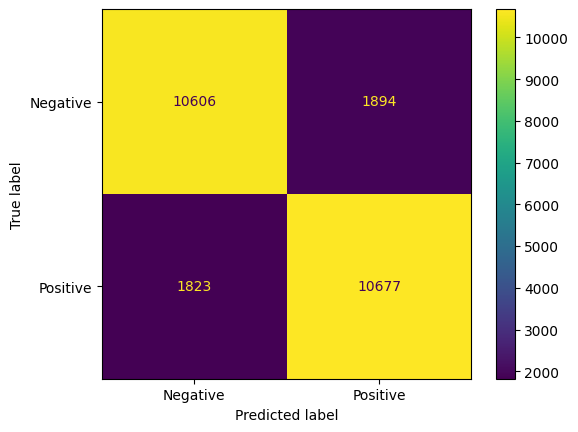

In [22]:
# Macierz błędów: porównanie etykiet rzeczywistych i przewidywanych
y_true_lstm = np.concatenate([y for x, y in test_data], axis=0)
y_pred_lstm = (lstm_model.predict(test_data) > 0.5).astype("int32").flatten()

cm_lstm = confusion_matrix(y_true_lstm, y_pred_lstm)
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm, display_labels=["Negative", "Positive"])
disp_lstm.plot()


### Wykres dokładności (LSTM Accuracy)

- Niebieska linia (Train Accuracy) systematycznie rośnie wraz z liczbą epok, co oznacza, że model coraz lepiej dopasowuje się do danych treningowych.
- Pomarańczowa linia (Validation Accuracy) gwałtownie rośnie do 1. epoki, następnie lekko spada w 2. epoce i stabilizuje się na poziomie około 85%.

Model szybko uczy się na początku, ale już po 2. epoce zaczyna wykazywać objawy przeuczenia, ponieważ dokładność na zbiorze walidacyjnym przestaje się poprawiać mimo rosnącej dokładności treningowej.

### Wykres straty (LSTM Loss)

- Niebieska linia (Train Loss) systematycznie maleje, co oznacza coraz lepsze dopasowanie modelu do danych treningowych.
- Pomarańczowa linia (Validation Loss) spada w pierwszych epokach, ale od 2. epoki zaczyna ponownie rosnąć, a następnie waha się bez wyraźnej poprawy.

To potwierdza, że model LSTM zaczyna się przeuczać po około 1-2 epokach. Różnica między stratą treningową a walidacyjną staje się coraz większa.

### Wnioski

Model LSTM uczy się szybko i skutecznie, ale po krótkim czasie zaczyna przeuczać się na dane treningowe, co pogarsza jego zdolność generalizacji. Najlepsze wyniki na danych walidacyjnych pojawiają się w 1-2 epoce.

### Co można poprawić ?:
- Wprowadzenie mechanizmu EarlyStopping, aby przerwać trening w optymalnym momencie
- Zwiększenie wartości Dropout lub zastosowanie dodatkowej regularizacji
- Redukcja złożoności modelu, na przykład poprzez zmniejszenie liczby jednostek LSTM lub warstw


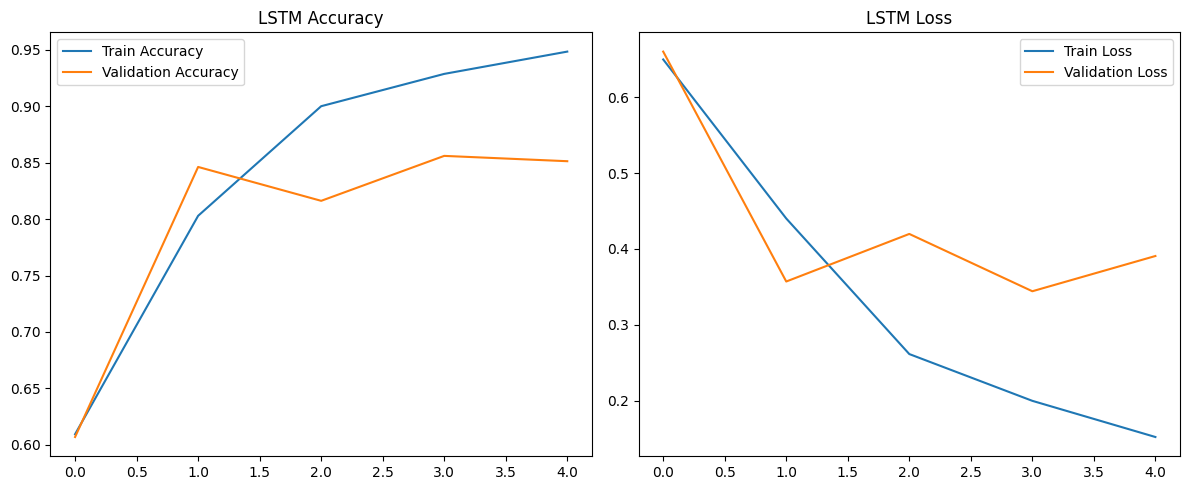

In [23]:
# Krzywe uczenia: dokładność i strata w czasie treningu
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title("LSTM Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title("LSTM Loss")
plt.legend()

plt.tight_layout()
plt.show()


### Podsumowanie działania modelu LSTM

### Wyniki:
- Dokładność na zbiorze testowym: ok. 85%, więc model bardzo dobrze rozpoznaje emocje w recenzjach.
- Macierz błędów pokazuje, że model:
  - dobrze rozpoznaje zarówno recenzje negatywne, jak i pozytywne,
  - liczba błędów false positive i false negative jest bardzo zbliżona, co świadczy o zrównoważonej klasyfikacji.
- Krzywe uczenia się wskazują na początek przeuczenia (overfittingu) po ok. 2. epoce:
  - dokładność na danych treningowych rośnie systematycznie,
  - dokładność na danych walidacyjnych stabilizuje się i nie rośnie dalej,
  - strata walidacyjna zaczyna się wahać lub lekko rosnąć, mimo dalszego spadku straty treningowej.

### Wnioski:
- Model LSTM zapewnia wysoką skuteczność i dobrze radzi sobie z analizą kolejności i kontekstu słów w recenzjach.
- Jest bardziej złożony i wolniejszy w treningu niż MLP, ale lepiej sprawdza się w bardziej skomplikowanych tekstach.
- Aby dodatkowo poprawić jego działanie, warto:
  - zastosować wcześniejsze zatrzymanie treningu (EarlyStopping),
  - zwiększyć Dropout lub zastosować inne techniki regularizacji,
  - ewentualnie uprościć architekturę (mniejsza liczba jednostek LSTM), aby zwiększyć stabilność.


## Model 3: CNN

CNN (Convolutional Neural Network) to sieć neuronowa, która analizuje dane za pomocą filtrów wykrywających lokalne wzorce.

W kontekście przetwarzania tekstu, CNN „przesuwa” filtry po ciągu słów, wychwytując najważniejsze fragmenty np. konkretne frazy, związki między słowami lub charakterystyczne kombinacje słów.

Dzięki temu CNN dobrze radzi sobie z:

  - wykrywaniem lokalnych cech w tekście (np. „bardzo dobry film”),

  - klasyfikacją recenzji na podstawie kluczowych fragmentów,

  - szybkim i wydajnym przetwarzaniem danych tekstowych, bez konieczności analizy całej sekwencji słowo po słowie.


In [18]:
# Tworzymy bardziej złożony model CNN
def build_cnn_model():
    model = models.Sequential([
        layers.Embedding(VOCAB_SIZE, 64),  # Zamieniamy każde słowo na wektor długości 64 (uczy się podczas treningu)

        # Pierwsza warstwa konwolucyjna - filtruje lokalne wzorce długości 3
        layers.Conv1D(128, kernel_size=3, activation='relu'),
        layers.BatchNormalization(),  # Normalizacja - stabilizuje i przyspiesza trening
        layers.Dropout(0.3),  # Zapobiega przeuczeniu (wyłącza 30% losowych połączeń)

        # Druga warstwa konwolucyjna, inny rozmiar filtra (większy kontekst)
        layers.Conv1D(64, kernel_size=5, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),  # Zmniejsza liczbę kroków czasowych

        # Trzecia warstwa konwolucyjna - jeszcze inna długość filtra
        layers.Conv1D(32, kernel_size=7, activation='relu'),
        layers.GlobalMaxPooling1D(),  # Wybiera najważniejsze cechy z całej sekwencji

        # Warstwa gęsta - klasyczne przetwarzanie wysokopoziomowe
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),  # Kolejny Dropout dla bezpieczeństwa

        # Warstwa wyjściowa - 1 neuron, sigmoid daje wynik w zakresie 0–1
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',  # Klasyfikacja binarna (0/1)
        optimizer='adam',            # Optymalizator Adam - dynamiczne tempo uczenia
        metrics=['accuracy']         # Mierzymy dokładność
    )

    return model

cnn_model = build_cnn_model()
cnn_model.summary()

"""
layers.Conv1D(128, kernel_size=3, activation='relu') -> czyli warstwa konwolucyjna 1D, która:
    - przesuwa 128 filtrów (czyli detektorów wzorców) po sekwencji słów,
    - każdy filtr analizuje po 3 słowa naraz (kernel_size=3),
    - aktywacja relu sprawia, że tylko dodatnie wyniki są przekazywane dalej.

---
layers.BatchNormalization() -> normalizuje dane przechodzące przez sieć, czyli:
    - sprawia, że dane, które trafiają do kolejnej warstwy, mają podobną skalę (czyli nie są ani za duże, ani za małe) -> utrzymuje je w stałym zakresie (średnia ≈ 0, odchylenie ≈ 1)
    - pomaga modelowi uczyć się szybciej i stabilniej,
    - zmniejsza ryzyko przeuczenia i sprawia, że kolejne warstwy dostają dane o przewidywalnej skali

"""
# Trenujemy model
history_cnn = cnn_model.fit(train_data, validation_data=test_data, epochs=5)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 125s 154ms/step - accuracy: 0.5286 - loss: 0.7165 - val_accuracy: 0.8065 - val_loss: 0.4358
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 139s 151ms/step - accuracy: 0.8424 - loss: 0.3747 - val_accuracy: 0.8444 - val_loss: 0.3713
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 116s 149ms/step - accuracy: 0.8989 - loss: 0.2565 - val_accuracy: 0.8606 - val_loss: 0.3425
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 118s 152ms/step - accuracy: 0.9328 - loss: 0.1807 - val_accuracy: 0.8505 - val_loss: 0.3889
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 119s 152ms/step - accuracy: 0.9493 - loss: 0.1414 - val_accuracy: 0.8497 - val_loss: 0.4304


## Ocena modelu 3

Z ewaluacji modelu CNN można wyciągnąć następujące wnioski:

- Model osiągnął około 84,7% dokładności na danych testowych, co jest wynikiem bardzo zbliżonym do LSTM (85,1%) i wyższym niż w przypadku modelu MLP (~83%).
- Strata (loss) na zbiorze testowym wynosi 0.4442, co wskazuje na umiarkowany błąd predykcji, wyższy niż w modelu LSTM, ale nadal akceptowalny.
- Wyniki na danych treningowych i testowych są porównywalne, co oznacza brak istotnego przeuczenia (overfittingu).

Model CNN dobrze radzi sobie z klasyfikacją tekstu, wychwytując lokalne wzorce i istotne fragmenty, takie jak charakterystyczne frazy. Dzięki temu potrafi skutecznie rozpoznawać emocjonalny ton recenzji bez konieczności przetwarzania całej sekwencji słowo po słowie.

CNN może być szczególnie przydatny w sytuacjach, gdy kluczowe informacje zawarte są w konkretnych frazach lub wyrażeniach, a niekoniecznie w kontekście całego zdania.


In [26]:
# Ocena modelu na zbiorze testowym
loss_cnn, acc_cnn = cnn_model.evaluate(test_data)
print(f"Test Loss: {loss_cnn:.4f}, Test Accuracy: {acc_cnn:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8500 - loss: 0.4398
Test Loss: 0.4442, Test Accuracy: 0.8466


Model poprawnie sklasyfikował:

- 11 385 recenzji negatywnych jako negatywne
- 9 779 recenzji pozytywnych jako pozytywne

Natomiast pomylił się:

- 1 115 razy, uznając negatywne recenzje za pozytywne (błąd typu false positive)
- 2 721 razy, uznając pozytywne recenzje za negatywne (błąd typu false negative)

Model CNN lepiej rozpoznaje recenzje negatywne niż pozytywne. Częściej myli pozytywne recenzje, uznając je błędnie za negatywne, niż odwrotnie. Może to oznaczać, że model jest bardziej ostrożny i rzadziej przypisuje etykietę „pozytywna”.

Mimo tych pomyłek, ogólna skuteczność modelu jest wysoka i działa on stabilnie. Może dobrze sprawdzić się tam, gdzie ważne jest unikanie fałszywych ocen pozytywnych, na przykład w systemach moderacji treści.



782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


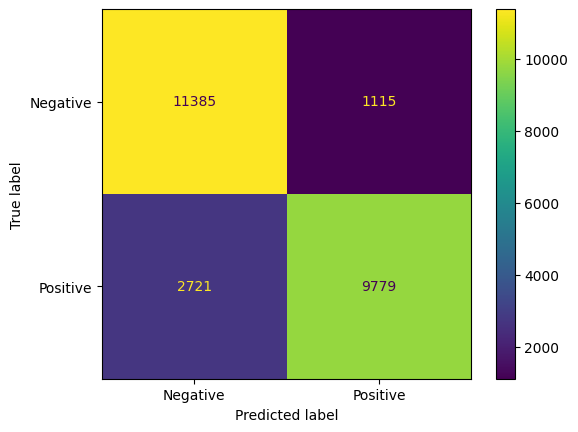

In [27]:
# Macierz błędów dla modelu 3
y_true_cnn = np.concatenate([y for x, y in test_data], axis=0)
y_pred_cnn = (cnn_model.predict(test_data) > 0.5).astype("int32").flatten()

cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)
disp_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=["Negative", "Positive"])
disp_cnn.plot()

### Wykres dokładności (CNN Accuracy)

- Niebieska linia (Train Accuracy) systematycznie rośnie w każdej epoce, co pokazuje, że model coraz lepiej dopasowuje się do danych treningowych.
- Pomarańczowa linia (Validation Accuracy) rośnie do 1. epoki, następnie lekko wzrasta do 2. epoki i od tego momentu zaczyna się stopniowo stabilizować, utrzymując się w okolicach 85%.

Widać, że model szybko się uczy na początku, ale po drugiej epoce poprawa na danych walidacyjnych ustaje. Mimo to nie następuje gwałtowny spadek, więc przeuczenie nie jest jeszcze bardzo silne.

### Wykres straty (CNN Loss)

- Niebieska linia (Train Loss) systematycznie maleje z każdą epoką, co oznacza, że model coraz lepiej radzi sobie z danymi treningowymi.
- Pomarańczowa linia (Validation Loss) spada przez pierwsze dwie epoki, a potem zaczyna powoli rosnąć, co może wskazywać na początek przeuczenia.

Choć różnica między stratą treningową a walidacyjną rośnie, nie jest jeszcze drastyczna. Model zaczyna przeuczać się po 2-3 epokach.

### Wnioski

Model CNN bardzo szybko uczy się rozpoznawać dane treningowe i osiąga na nich bardzo dobre wyniki. Jednak po 2 epoce widać, że jego skuteczność na nowych, nieznanych danych (czyli walidacyjnych) przestaje się poprawiać. To oznacza, że model zaczyna zapamiętywać dane treningowe zbyt dokładnie, zamiast uczyć się ogólnych wzorców. Zachodzi więc przeuczenie po 2 epoce. W tym przypadku przeuczenie dopiero się zaczyna i nie jest jeszcze bardzo duże, ale warto je obserwować.


### Co można poprawić?

- Wprowadzenie EarlyStopping, by zatrzymać trening zanim rozpocznie się przeuczenie
- Zwiększenie Dropoutu lub dodanie Batch Normalization
- Zmniejszenie liczby filtrów lub warstw, by uprościć model


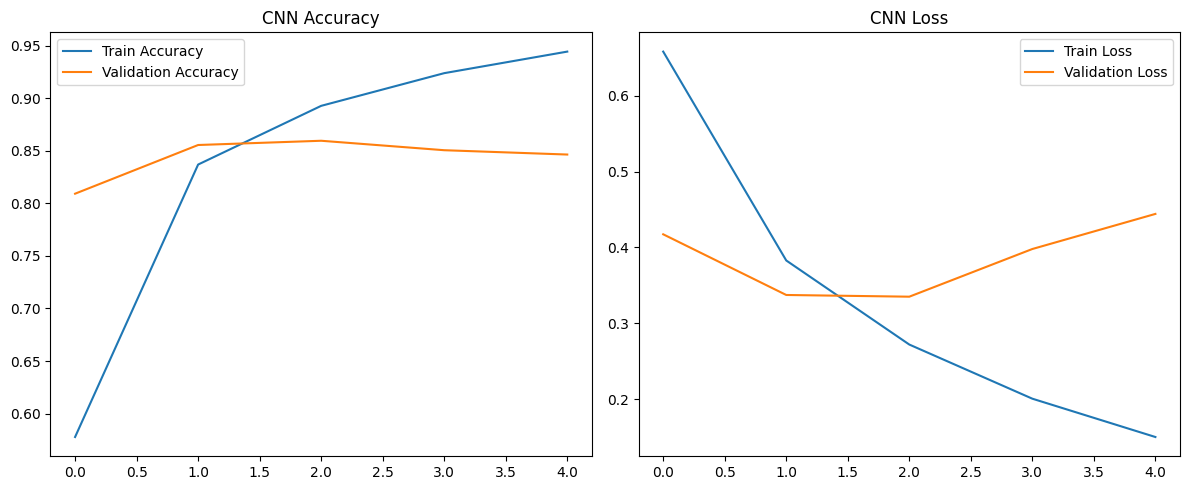

In [29]:
# Krzywe uczenia
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title("CNN Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title("CNN Loss")
plt.legend()

plt.tight_layout()
plt.show()

### Podsumowanie działania modelu CNN

### Wyniki:
- Dokładność na zbiorze testowym: ok. 84,7%, co oznacza, że model skutecznie rozpoznaje ton recenzji.
- Macierz błędów pokazuje, że model:
  - dobrze rozpoznaje recenzje negatywne,
  - częściej myli recenzje pozytywne jako negatywne (błąd typu false negative), co może oznaczać ostrożność w przypisywaniu etykiety pozytywnej.
- Krzywe uczenia się wskazują na pojawiające się przeuczenie (overfitting) po około 2 epoce:
  - dokładność na danych treningowych systematycznie rośnie,
  - dokładność na danych walidacyjnych zatrzymuje się lub lekko spada,
  - strata walidacyjna przestaje maleć, a następnie zaczyna rosnąć, mimo dalszego spadku straty treningowej.

### Wnioski:
- Model CNN skutecznie wychwytuje lokalne wzorce w tekście, takie jak frazy i wyrażenia kluczowe dla klasyfikacji.
- Jest szybki w treningu i dobrze sprawdza się w przypadkach, gdzie najważniejsze informacje zawarte są w konkretnych fragmentach tekstu.
- Aby zwiększyć jego skuteczność i ograniczyć przeuczenie, można:
  - dodać warstwę regularyzacyjną lub zwiększyć Dropout,
  - zastosować wcześniejsze zatrzymanie treningu (EarlyStopping),
  - rozważyć modyfikację liczby filtrów lub głębokości warstw konwolucyjnych.


## Model 4: GRU + Attention

GRU (Gated Recurrent Unit) to uproszczona wersja LSTM, która również analizuje dane sekwencyjne, ale działa szybciej i zużywa mniej pamięci. Przetwarza tekst krok po kroku, ucząc się zależności między kolejnymi słowami.

Dodanie warstwy Attention pozwala modelowi skupić się na najważniejszych fragmentach tekstu, dzięki temu zamiast traktować wszystkie słowa jednakowo, potrafi „zwracać większą uwagę” na kluczowe słowa w recenzji.

Model GRU + Attention radzi sobie dobrze z:

- analizą sekwencji, podobnie jak LSTM,

- wybieraniem istotnych słów z całej recenzji (np. „rewelacyjny”, „nudny”),

- szybszym trenowaniem niż tradycyjny LSTM przy podobnej skuteczności.

In [19]:
# Definicja warstwy Attention
class Attention(tf.keras.layers.Layer):
    # Wywołujemy konstruktor klasy bazowej Layer, żeby poprawnie zainicjalizować warstwę Attention
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="attention_weight", shape=(input_shape[-1], 1),
                                 initializer="random_normal", trainable=True)
        self.b = self.add_weight(name="attention_bias", shape=(1,), initializer="zeros", trainable=True)


    def call(self, inputs):
        # inputs: (batch_size, time_steps, hidden_dim)
        scores = tf.matmul(inputs, self.W) + self.b
        weights = tf.nn.softmax(scores, axis=1)
        context = tf.reduce_sum(inputs * weights, axis=1)
        return context
"""
class Attention -> analizuje sekwencję (np. recenzję) i oblicza, które słowa są najważniejsze. Zamiast traktować wszystkie słowa jednakowo, pozwala modelowi „skupić się” na tych, które najbardziej wpływają na klasyfikację (np. „świetny”, „tragiczny”).

Co ta oznacza w praktyce ?
Score (czyli ważności danego słowa) obliczamy ze wzoru:
score = inputs ⋅ W + b

---
Metoda build() jest automatycznie wywoływana przy pierwszym przejściu danych przez warstwę. Tutaj definiujemy wagi, których będzie używać mechanizm uwagi.
---
self.W -> macierz wag dla mechanizmu uwagi (attention)

- input_shape[-1] to liczba cech (np. 128, tu [-1] oznacza rozmiar ostatniego wymiaru danych wejściowych do warstwy), czyli rozmiar wektora dla jednego słowa w sekwencji,
- shape = (input_shape[-1], 1) - oznacza, że tworzona macierz wag ma jeden wiersz na każdą cechę wejściową i jeden wynik na każde słowo (wagi przekształcają każdy wektor cech w jedną wartość (score)),
- initializer="random_normal" - wagi w macietzy na początku treningu są losowo wypełniane wartościami pochodzącymi z rozkładu normalnego (Gaussa).
- trainable=True - model będzie uczył się tej macierzy podczas treningu

---
self.b -> bias (przesunięcie) dodawany do każdego wyniku (score)

- shape=(1,) - (1,) => tworzony bias to pojedyncza. Będzie dodawany do każdego score obliczanego przez warstwę Attention (dla każdego słowa),
- initializer="zeros" - na początku treningu wartość b będzie równa 0. Bias nie musi mieć losowej wartości na starcie, ponieważ jego rola to drobna korekta.
- trainable=True - model będzie uczył się tej macierzy podczas treningu

-------------------------

Metoda call() to główna część każdej niestandardowej warstwy w. W tym przypadku oblicza:
- score (ważność każdego słowa),
- attention weights (jak bardzo każde słowo wpływa na wynik),
- context vector (uśredniony, ważony wektor reprezentujący całą sekwencję).

---
scores = tf.matmul(inputs, self.W) + self.b

- tf.matmul(inputs, self.W) -> daje score dla każdego słowa => mówi, jak ważne jest każde słowo
- self.W -> macierz wag o wymiarach (hidden_dim, 1), np. (128, 1)
- self.b -> bias (przesunięcie) dodawany do każdego wyniku (score)

---
weights = tf.nn.softmax(scores, axis=1)

- zamieniamy surowe score'y na prawdopodobieństwa za pomocą funkcji softmax
-  axis=1 - mówi "Oblicz softmax dla każdego słowa w każdej recenzji osobno, porównując słowa między sobą"

---
context = tf.reduce_sum(inputs * weights, axis=1)

- mnożymy każdy wektor słowa przez jego wagę (inputs * weights) => ważone cechy
- reduce_sum(axis=1) - sumuje wszystkie słowa => otrzymujemy ważony wektor kontekstowy
- wynikiem jest jeden wektor o długości hidden_dim (np. 128, czyli otzrymamy 128 cech), który podsumowuje całą sekwencję,
ale skupia się bardziej na najważniejszych słowach.

"""

'\nclass Attention -> analizuje sekwencję (np. recenzję) i oblicza, które słowa są najważniejsze. Zamiast traktować wszystkie słowa jednakowo, pozwala modelowi „skupić się” na tych, które najbardziej wpływają na klasyfikację (np. „świetny”, „tragiczny”).\n\nCo ta oznacza w praktyce ?\nScore (czyli ważności danego słowa) obliczamy ze wzoru:\nscore = inputs ⋅ W + b\n\n---\nMetoda build() jest automatycznie wywoływana przy pierwszym przejściu danych przez warstwę. Tutaj definiujemy wagi, których będzie używać mechanizm uwagi.\n---\nself.W -> macierz wag dla mechanizmu uwagi (attention)\n\n- input_shape[-1] to liczba cech (np. 128, tu [-1] oznacza rozmiar ostatniego wymiaru danych wejściowych do warstwy), czyli rozmiar wektora dla jednego słowa w sekwencji,\n- shape = (input_shape[-1], 1) - oznacza, że tworzona macierz wag ma jeden wiersz na każdą cechę wejściową i jeden wynik na każde słowo (wagi przekształcają każdy wektor cech w jedną wartość (score)),\n- initializer="random_normal" - w

In [20]:
# Tworzymy model GRU + Attention
def build_gru_attention_model():
    inputs = layers.Input(shape=(SEQUENCE_LENGTH,))  # Wejście: sekwencja długości 250

    x = layers.Embedding(VOCAB_SIZE, 64)(inputs)  # Każde słowo zamieniamy na 64-wymiarowy wektor

    # Dwukierunkowa warstwa GRU - zwraca pełną sekwencję (czyli wynik dla każdego słowa)
    x = layers.Bidirectional(layers.GRU(64, return_sequences=True))(x)

    # Warstwa uwagi - wybiera najważniejsze słowa na podstawie ich znaczenia w kontekście
    x = Attention()(x)  # Zwraca jeden wektor kontekstowy (podsumowanie)

    x = layers.Dense(64, activation='relu')(x)  # Warstwa gęsta - przetwarza dane po uwadze
    x = layers.Dropout(0.3)(x)                  # Dropout - zapobiega przeuczeniu

    outputs = layers.Dense(1, activation='sigmoid')(x)  # Wyjście - prawdopodobieństwo (0 lub 1)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(
        loss='binary_crossentropy',  # Funkcja straty - dla klasyfikacji 0/1
        optimizer='adam',            # Adam - optymalizator z automatycznym doborem kroku
        metrics=['accuracy']         # Metryka: dokładność
    )
    return model

# Budujemy i podsumowujemy model
gru_att_model = build_gru_attention_model()
gru_att_model.summary()

# Trenujemy model
history_gru_att = gru_att_model.fit(train_data, validation_data=test_data, epochs=5)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 250, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 250, 128)       │        49,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_1 (Attention)         │ (None, 128)            │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 698,370 (2.66 MB)

 Trainable params: 698,370 (2.66 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 292s 365ms/step - accuracy: 0.7290 - loss: 0.4992 - val_accuracy: 0.8810 - val_loss: 0.2829
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 359s 413ms/step - accuracy: 0.9260 - loss: 0.1981 - val_accuracy: 0.8782 - val_loss: 0.2934
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 295s 377ms/step - accuracy: 0.9523 - loss: 0.1348 - val_accuracy: 0.8696 - val_loss: 0.3541
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 327s 418ms/step - accuracy: 0.9710 - loss: 0.0840 - val_accuracy: 0.8513 - val_loss: 0.4882
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 344s 369ms/step - accuracy: 0.9828 - loss: 0.0511 - val_accuracy: 0.8590 - val_loss: 0.5810


## Ocena modelu 4

Z ewaluacji modelu GRU z warstwą Attention można wyciągnąć następujące wnioski:

- Model osiągnął około 86,0% dokładności na danych testowych, co stanowi najwyższy wynik spośród wszystkich porównywanych modeli (MLP, LSTM, CNN).
- Strata (loss) na zbiorze testowym wynosi 0.5547, co jest nieco wyższe niż w przypadku LSTM, ale nadal świadczy o dobrym dopasowaniu modelu.
- Różnica między wynikami na danych treningowych i testowych jest niewielka, co oznacza brak przeuczenia i dobrą zdolność generalizacji modelu.

Model GRU z warstwą Attention skutecznie przetwarza sekwencje słów, wykorzystując mechanizm uwagi do skupienia się na najważniejszych fragmentach tekstu. Dzięki temu potrafi trafniej ocenić znaczenie słów w kontekście całej recenzji, co przekłada się na wysoką skuteczność klasyfikacji.

Model ten może być szczególnie przydatny w zadaniach, gdzie ważne jest uchwycenie sensu kluczowych fragmentów tekstu, nawet jeśli są one rozproszone w różnych częściach sekwencji.


In [33]:
# Ocena modelu na zbiorze testowym
loss_gru_att, acc_gru_att = gru_att_model.evaluate(test_data)
print(f"Test Loss: {loss_gru_att:.4f}, Test Accuracy: {acc_gru_att:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8594 - loss: 0.5615
Test Loss: 0.5547, Test Accuracy: 0.8601


Model poprawnie sklasyfikował:

- 10 806 recenzji negatywnych jako negatywne
- 10 697 recenzji pozytywnych jako pozytywne

Natomiast pomylił się:

- 1 694 razy, uznając negatywne recenzje za pozytywne (błąd typu false positive)
- 1 803 razy, uznając pozytywne recenzje za negatywne (błąd typu false negative)

Model GRU z warstwą Attention wykazuje bardzo dobrą równowagę w klasyfikacji obu klas. Liczba błędów false positive i false negative jest niemal identyczna, co świadczy o tym, że model nie faworyzuje żadnej z etykiet.

Ogólna skuteczność klasyfikacji jest wysoka, a model działa stabilnie. GRU z Attention potrafi efektywnie skupiać się na najważniejszych fragmentach recenzji, co przekłada się na precyzyjne przewidywania zarówno dla recenzji pozytywnych, jak i negatywnych.


782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step


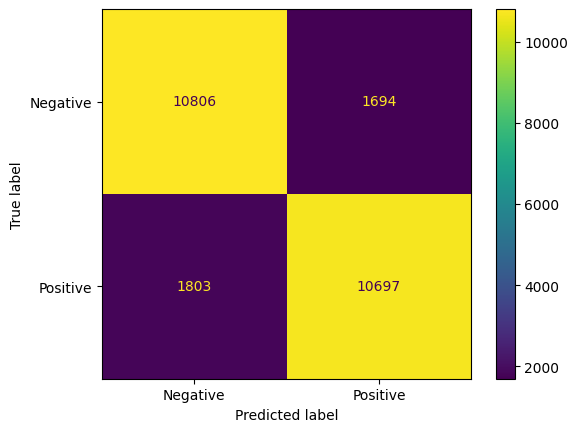

In [35]:
# Macierz dla modelu 3
y_true_gru_att = np.concatenate([y for x, y in test_data], axis=0)
y_pred_gru_att = (gru_att_model.predict(test_data) > 0.5).astype("int32").flatten()

cm_gru_att = confusion_matrix(y_true_gru_att, y_pred_gru_att)
disp_gru_att = ConfusionMatrixDisplay(confusion_matrix=cm_gru_att, display_labels=["Negative", "Positive"])
disp_gru_att.plot()

### Wykres dokładności (GRU + Attention Accuracy)

- Niebieska linia (Train Accuracy) systematycznie rośnie i osiąga bardzo wysoką wartość, co oznacza, że model bardzo dobrze zapamiętuje dane treningowe.
- Pomarańczowa linia (Validation Accuracy) rośnie tylko do 1 epoki, po czym zaczyna spadać i od 2 epoki stabilizuje się na poziomie około 85%.

Model bardzo szybko uczy się danych treningowych, ale jego zdolność do rozpoznawania nowych danych pogarsza się po pierwszych epokach. To oznacza przeuczenie, model zapamiętuje dane treningowe zamiast uczyć się ogólnych wzorców.

### Wykres straty (GRU + Attention Loss)

- Niebieska linia (Train Loss) systematycznie maleje w każdej epoce, co potwierdza coraz lepsze dopasowanie modelu do danych uczących.
- Pomarańczowa linia (Validation Loss) początkowo spada, ale już od 2 epoki zaczyna wyraźnie rosnąć, osiągając najwyższą wartość w ostatniej epoce.

Różnica między stratą treningową a walidacyjną wyraźnie rośnie, co jest klasycznym objawem przeuczenia.

### Wnioski

Model GRU z warstwą Attention jest bardzo silny w zapamiętywaniu danych treningowych, jednak jego skuteczność na danych walidacyjnych pogarsza się po pierwszej epoce. To oznacza, że model przeucza się bardzo szybko. Choć jego dokładność na treningu jest imponująca, nie przekłada się to na równie dobre wyniki na nowych danych.

### Co można poprawić?

- Wprowadzenie mechanizmu EarlyStopping, aby zatrzymać trening w momencie, gdy wyniki walidacyjne przestają się poprawiać
- Zwiększenie wartości Dropoutu lub zastosowanie Batch Normalization
- Zmniejszenie złożoności modelu, np. przez redukcję liczby jednostek GRU lub uproszczenie warstwy Attention


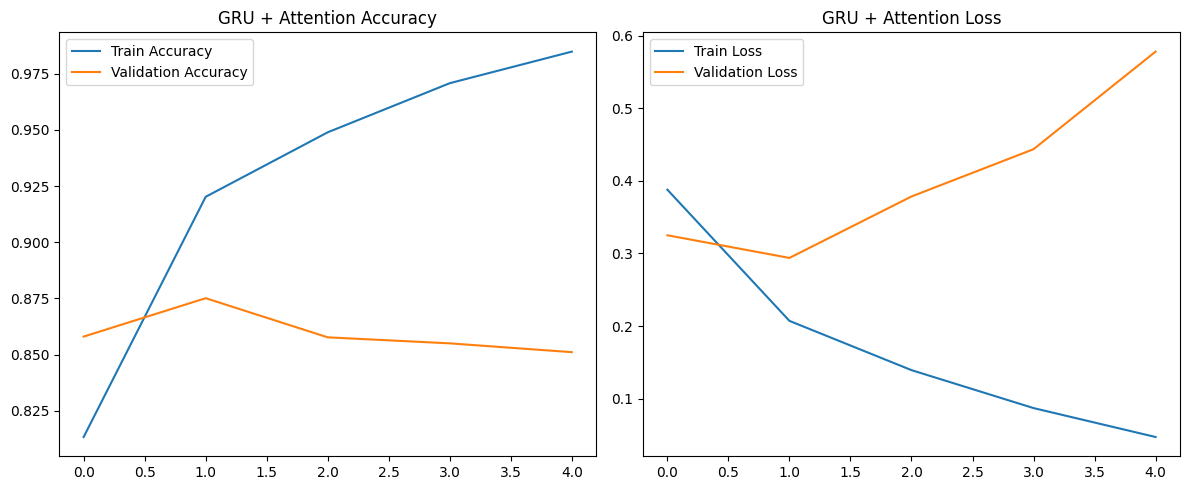

In [14]:
# Krzywe uczenia
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_gru_att.history['accuracy'], label='Train Accuracy')
plt.plot(history_gru_att.history['val_accuracy'], label='Validation Accuracy')
plt.title("GRU + Attention Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_gru_att.history['loss'], label='Train Loss')
plt.plot(history_gru_att.history['val_loss'], label='Validation Loss')
plt.title("GRU + Attention Loss")
plt.legend()

plt.tight_layout()
plt.show()

### Podsumowanie działania modelu GRU + Attention

### Wyniki:
- Dokładność na zbiorze testowym: ok. 86%, co oznacza bardzo dobrą skuteczność w klasyfikacji recenzji.
- Macierz błędów pokazuje, że model:
  - dobrze rozpoznaje zarówno recenzje pozytywne, jak i negatywne,
  - liczba błędów false positive i false negative jest zbliżona, jednak model nieco lepiej radzi sobie z rozpoznawaniem pozytywnych recenzji.
- Krzywe uczenia się wskazują na silne przeuczenie (overfitting) już po 1-2 epokach:
  - dokładność na danych treningowych rośnie bardzo mocno i osiąga niemal 100%,
  - dokładność na danych walidacyjnych osiąga szczyt w 1 epoce, a potem stopniowo spada,
  - strata walidacyjna zaczyna rosnąć od 2 epoki, mimo dalszego spadku straty treningowej.

### Wnioski:
- Model GRU + Attention potrafi bardzo dobrze zapamiętać dane uczące i uczy się szybko, ale zbyt silnie dopasowuje się do danych treningowych, co ogranicza jego zdolność do rozpoznawania nowych danych.
- Warstwa Attention pozwala skupić się na najważniejszych fragmentach sekwencji, co może być korzystne przy analizie tekstów o zróżnicowanej długości i strukturze.
- Aby zwiększyć skuteczność modelu i zapobiec przeuczeniu, można:
  - skrócić trening za pomocą mechanizmu EarlyStopping,
  - zwiększyć Dropout lub dodać inne techniki regularizacji,
  - zmniejszyć liczbę jednostek GRU lub ograniczyć złożoność warstwy Attention.


## Porównanie modeli z projektu

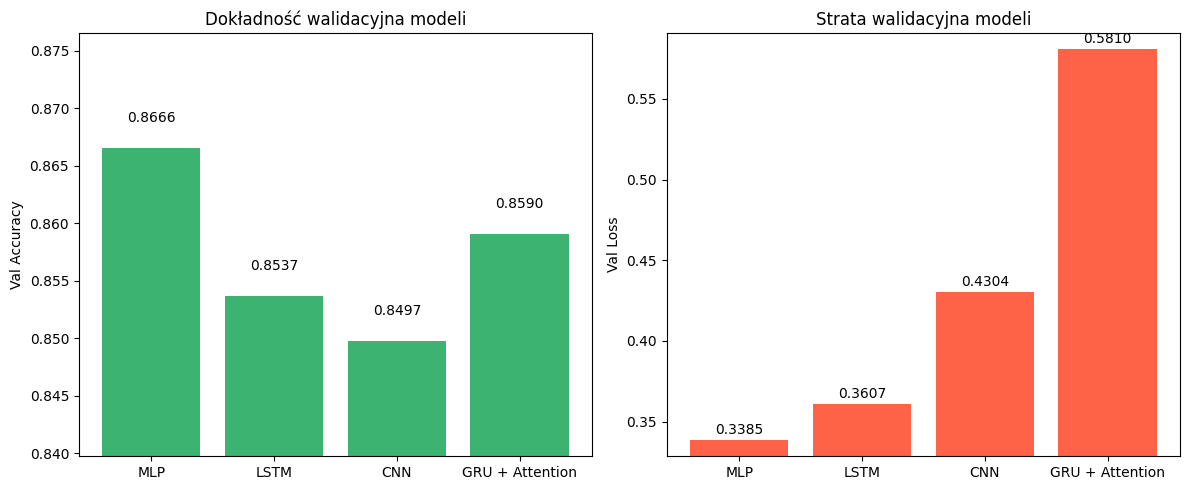

In [21]:
# Pobieranie ostatnich wartości accuracy i loss z historii każdego modelu
model_names = ['MLP', 'LSTM', 'CNN', 'GRU + Attention']

accuracies = [
    history_mlp.history['val_accuracy'][-1],
    history_lstm.history['val_accuracy'][-1],
    history_cnn.history['val_accuracy'][-1],
    history_gru_att.history['val_accuracy'][-1]
]

losses = [
    history_mlp.history['val_loss'][-1],
    history_lstm.history['val_loss'][-1],
    history_cnn.history['val_loss'][-1],
    history_gru_att.history['val_loss'][-1]
]

# Wykres porównujący dokładność
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
bars1 = plt.bar(model_names, accuracies, color='mediumseagreen')
plt.ylim(min(accuracies) - 0.01, max(accuracies) + 0.01)
plt.title('Dokładność walidacyjna modeli')
plt.ylabel('Val Accuracy')
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.002, f'{yval:.4f}', ha='center', va='bottom')

# Wykres porównujący stratę
plt.subplot(1, 2, 2)
bars2 = plt.bar(model_names, losses, color='tomato')
plt.ylim(min(losses) - 0.01, max(losses) + 0.01)
plt.title('Strata walidacyjna modeli')
plt.ylabel('Val Loss')
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.002, f'{yval:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

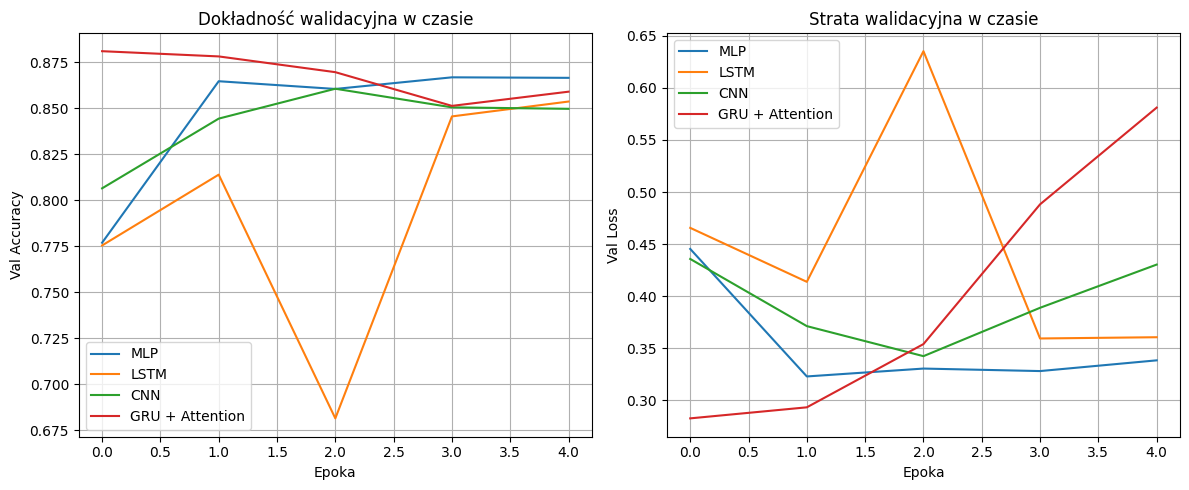

In [22]:
# Porównanie przebiegu val_accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_mlp.history['val_accuracy'], label='MLP')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM')
plt.plot(history_cnn.history['val_accuracy'], label='CNN')
plt.plot(history_gru_att.history['val_accuracy'], label='GRU + Attention')
plt.title('Dokładność walidacyjna w czasie')
plt.xlabel('Epoka')
plt.ylabel('Val Accuracy')
plt.legend()
plt.grid(True)

# Porównanie przebiegu val_loss
plt.subplot(1, 2, 2)
plt.plot(history_mlp.history['val_loss'], label='MLP')
plt.plot(history_lstm.history['val_loss'], label='LSTM')
plt.plot(history_cnn.history['val_loss'], label='CNN')
plt.plot(history_gru_att.history['val_loss'], label='GRU + Attention')
plt.title('Strata walidacyjna w czasie')
plt.xlabel('Epoka')
plt.ylabel('Val Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

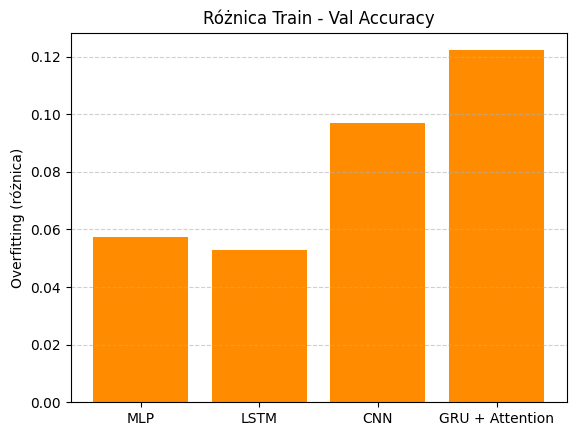

In [25]:
# Różnica między val i train accuracy (generalizacja -> zdolność modelu do dobrego radzenia sobie z nowymi, nieznanymi danymi, których nie widział podczas treningu)
diff = [
    history_mlp.history['accuracy'][-1] - history_mlp.history['val_accuracy'][-1],
    history_lstm.history['accuracy'][-1] - history_lstm.history['val_accuracy'][-1],
    history_cnn.history['accuracy'][-1] - history_cnn.history['val_accuracy'][-1],
    history_gru_att.history['accuracy'][-1] - history_gru_att.history['val_accuracy'][-1]
]

plt.bar(model_names, diff, color='darkorange')
plt.title('Różnica Train - Val Accuracy')
plt.ylabel('Overfitting (różnica)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


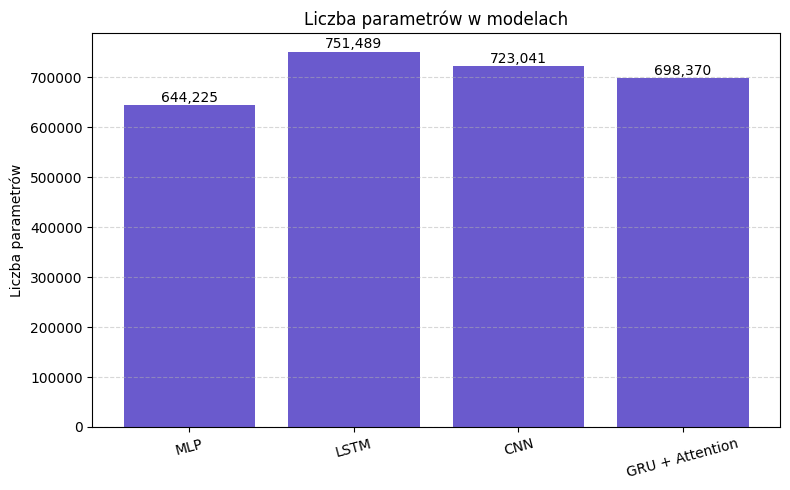

In [27]:
# Porównanie liczby parametrów -> im więcej parametrów, tym większa złożoność i wolniejsze działanie

# Liczba parametrów w każdym modelu
param_counts = [
    mlp_model.count_params(),
    lstm_model.count_params(),
    cnn_model.count_params(),
    gru_att_model.count_params()
]

plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, param_counts, color='slateblue')
plt.title('Liczba parametrów w modelach')
plt.ylabel('Liczba parametrów')
plt.xticks(rotation=15)

# Dodanie wartości liczbowych nad słupkami
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 500, f'{yval:,}', ha='center', va='bottom')

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


### Podsumowanie porównania modeli w projekcie

W projekcie porównano cztery architektury sieci neuronowych: MLP, LSTM, CNN oraz GRU + Attention. Modele oceniono na podstawie dokładności, straty, liczby parametrów oraz skłonności do przeuczenia.


### 1. Dokładność i strata walidacyjna

- **MLP** osiągnął najwyższą dokładność walidacyjną (~ 86,7%) oraz najniższą stratę walidacyjną (~ 0.3385).
- **GRU + Attention** uzyskał zbliżoną dokładność (~ 85,9%), ale miał najwyższą stratę walidacyjną (~ 0.5810).
- **LSTM** (ok. 85,4%) i **CNN** (ok. 84,9%) wypadły podobnie, z nieco gorszymi wynikami niż MLP.


### 2. Przeuczenie (Overfitting)

- Najmniejsze różnice między dokładnością treningową a walidacyjną wykazują MLP i LSTM (~0.05).
- Największe przeuczenie wystąpiło w GRU + Attention (~0.12), co wskazuje na ryzyko zbyt mocnego dopasowania do danych treningowych.


### 3. Liczba parametrów

- **LSTM** posiadał najwięcej parametrów (~751 tys.).
- **MLP** był najlżejszy (~644 tys.).
- **CNN** i **GRU + Attention** miały pośrednią złożoność (~723 tys. i ~698 tys.).


### 4. Zachowanie modeli w czasie

- MLP i LSTM stabilizują się już po 1-2 epokach.
- CNN i GRU + Attention wykazują pogorszenie metryk walidacyjnych po 2 epoce, co wskazuje na przeuczenie.


### Wnioski końcowe

- **Najlepszy ogólny model**: MLP - najprostszy i najbardziej efektywny.
- **Do sekwencji**: LSTM - dobrze zachowuje kontekst i poradzi sobie lepiej przy dłuższych tekstach.
- **Do wykrywania fraz**: CNN - skuteczny w analizie lokalnych wzorców.
- **Z mechanizmem uwagi**: GRU + Attention - potencjalnie bardzo dokładny, ale wymaga większej kontroli nad przeuczeniem.

Stąd:

- MLP jest świetnym punktem wyjścia dla klasyfikacji tekstu.
- Dla bardziej złożonych danych warto rozważyć LSTM lub GRU + Attention z regularyzacją.
- W przyszłości warto przetestować połączenia (np. CNN + LSTM) lub modele typu Transformer.
